In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory (
    "plantvillage",
    shuffle    = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


2022-08-23 08:55:39.201575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 08:55:39.202378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-23 08:55:39.202451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-23 08:55:39.202510: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-23 08:55:39.202569: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [9]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

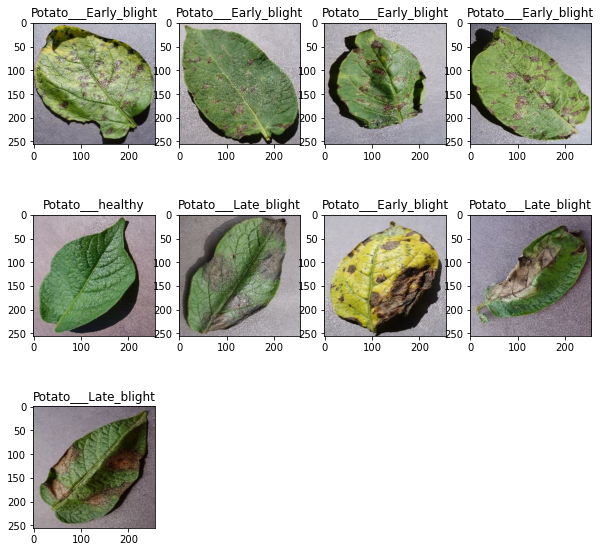

In [23]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])

In [27]:
train_size = .8
len(dataset)*train_size

54.400000000000006

In [25]:
train_dataset = dataset.take(54)
len(train_dataset)


54

In [29]:
test_size = .2
len(dataset)*test_size

13.600000000000001

In [26]:
test_dataset = dataset.skip(54)
len(test_dataset)

14

In [30]:
val_size = .1
len(dataset)*val_size

6.800000000000001

In [32]:
val_dataset = test_dataset.skip(6)
len(val_dataset)

8

In [33]:
test_dataset = test_dataset.skip(6)
len(test_dataset)

8

In [34]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1,test_split=0.1, shuffle=True, shuffle_size=10000):
    dataset_size = len(dataset)
    if shuffle:
        dataset  = dataset.shuffle(shuffle_size, seed=12)
    train_size   = int(train_split * dataset_size)
    val_size     = int(val_split * dataset_size)
    train_dataset= dataset.take(train_size)
    val_dataset  = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size).skip(val_size)
    return train_dataset, val_dataset, test_dataset

In [35]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [36]:
len(train_dataset)

54

In [38]:
train_dataset =train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset= test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
  


In [41]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [44]:
CHANNELS=3
EPOCHS=50

In [49]:
input_shape = (BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE , CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [52]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2022-08-23 11:17:24.720888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31 of 10000
2022-08-23 11:17:34.001583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-08-23 11:17:34.001613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-08-23 11:17:34.001759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


54/54 [==============================] - 96s 1s/step - loss: 0.8726 - accuracy: 0.5226 - val_loss: 0.7331 - val_accuracy: 0.7396
Epoch 2/50
54/54 [==============================] - 79s 1s/step - loss: 0.5044 - accuracy: 0.7980 - val_loss: 0.3922 - val_accuracy: 0.8229
Epoch 3/50
54/54 [==============================] - 79s 1s/step - loss: 0.3574 - accuracy: 0.8542 - val_loss: 0.2907 - val_accuracy: 0.8750
Epoch 4/50
54/54 [==============================] - 74s 1s/step - loss: 0.2320 - accuracy: 0.9132 - val_loss: 0.1478 - val_accuracy: 0.9375
Epoch 5/50
54/54 [==============================] - 75s 1s/step - loss: 0.2080 - accuracy: 0.9172 - val_loss: 0.1710 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 74s 1s/step - loss: 0.1377 - accuracy: 0.9439 - val_loss: 0.1496 - val_accuracy: 0.9427
Epoch 7/50
54/54 [==============================] - 76s 1s/step - loss: 0.1721 - accuracy: 0.9334 - val_loss: 0.1497 - val_accuracy: 0.9531
Epoch 8/50
 7/54 [==>..........

KeyboardInterrupt: 

In [53]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 3s 322ms/step - loss: 0.1160 - accuracy: 0.9609


In [59]:
model.save("../potatoes.h5")

In [57]:
model.save("../potatoes.h5")